#  **Rainbow DQN: all together**
In this lab we are going to implement Deep Q-Network Algorithm

# **Initialization**

## Install dependencies

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt-get update
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gym[classic_control]
    #!pip install gym==0.21.0
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net

## Import Dependencies

In [ ]:
import os
from typing import Dict, List, Tuple
import math, random

import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import base64
import glob
import io
import os


import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F


from IPython.display import HTML, display, clear_output



#**Implementation** 

## **Show recorded video**
The following functions are used in order to show in a video the obtained results

In [ ]:
def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))

def remove_videos (video_folder: str):
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    for video in list_of_files:
      try:
          os.remove(video)
      except:
          print("Error while deleting file : ", video)

def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    print("files: ", list_of_files )
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file

def show_all_videos(video_folder: str) -> str:
    """Show all the videos recorded."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    print("files: ", list_of_files )
    for video in list_of_files:
      ipython_show_video(video)
    print("Played:", video)


## Use Cuda

In [ ]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

## Replay Buffer

In [ ]:
from numpy.core.numeric import indices

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        #******Añadido David*******
        # array con las prioridades de cada experiencia en el buffer, para luego calcular la probabilidad de que se samplee
        #self.prioridades = np.zeros(capacity)
        self.prioridades = []
        # beta=0.4, para el importance sampling
        self.beta = 0.4
        # kappa (k) = 0.6
        self.kappa = 0.6
        #**************************
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
                
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
            #******Añadido*******
            self.prioridades.append(1)
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
            self.prioridades[self.pos] = max(self.prioridades)
            

        self.pos = (self.pos + 1) % self.capacity
    
    #*****Añadido*****
    #dado el peso delta y el indice, lo actualiza en el array de prioridades
    def actualizar_peso(self, delta, indice):
      # elevamos delta^2 (recomendacion de las tranparencias)
      # self.prioridades[indice] = pow(delta,2)
      # otra solucion: utilizar el valor absoluto en vez de ^2, como pone en las transparencias
      self.prioridades[indice] = abs(delta)
    #************************


    # HELP:
    # It can be helpful to use the following sequence:  
    #   indices = random.choices(range(0,len(self.buffer)), weights=probabilities, k=batch_size )
    # It samples "k" elements following "probabilities" distribution and returns the indices of the sampled elements
    # Instead of this sequence you can also use numpy tools
    def sample(self, batch_size):

        #******Añadido*******

        #calcular las probabilidades de las experiencias probabilities[j] = prioridad[j]^kappa / sum(prioridad ^ kappa)
        prioridadesNumpy = np.array(self.prioridades)
        probabilities = np.zeros(len(self.buffer)-1)
        probabilities = pow(prioridadesNumpy, self.kappa)
        probabilities = probabilities / np.sum(probabilities)

        #obtener batch_size elementos siguiendo las probabilidades calculadas 
        #obtenemos una lista con los indices de las experiencias elegidas
        indices = random.choices(range(0,len(self.buffer)), weights=probabilities, k=batch_size )

        #obtenemos las experiencias elegidas a partir de los indices obtenidos
        exp_elegidas = []
        prob_elegidas = []
        for i in indices:
          exp_elegidas.append(self.buffer[i])
          prob_elegidas.append(probabilities[i])

        #la pasamos a numpy array para que sea más facil operar
        prob_elegidas = np.array(prob_elegidas)

        #importance sampling  w[i] = ( (1/N) * (1 / probabilities[i]) ) ^beta
        N = len(self.buffer)
        w = np.zeros(batch_size)
        w = pow( ((1/N) * (1/prob_elegidas)) , self.beta)
        w = w / w.max() #para normalizar

        state, action, reward, next_state, done = zip(*exp_elegidas)
        
        return np.concatenate(state), action, reward, np.concatenate(next_state), done, w

        #**************************
        
        #*****Comentado David******
        #state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        #return np.concatenate(state), action, reward, np.concatenate(next_state), done


    def __len__(self):
        return len(self.buffer)

### Testing Replay Buffer

In [ ]:
# We build a Replay buffer for 5 elements
rB = ReplayBuffer(5)

# We are going to add 8 elements
for i in range(8):
  rB.push(i,i,i,i,i)
print("We add 8 elements but there are only ", len(rB), "\nrB: ", rB.buffer)

# We are going to add another value
rB.push(10,10,10,10,10)
print("\nAfter we add a new element the buffer is: ", rB.buffer)

# No we are going to see are sampled some experiences
mini_batch = rB.sample(2)
print("\n The sampled elemenst: ", mini_batch )

mini_batch = rB.sample(3)
print("\n The sampled elemenst: ", mini_batch )


We add 8 elements but there are only  5 
rB:  [(array([5]), 5, 5, array([5]), 5), (array([6]), 6, 6, array([6]), 6), (array([7]), 7, 7, array([7]), 7), (array([3]), 3, 3, array([3]), 3), (array([4]), 4, 4, array([4]), 4)]

After we add a new element the buffer is:  [(array([5]), 5, 5, array([5]), 5), (array([6]), 6, 6, array([6]), 6), (array([7]), 7, 7, array([7]), 7), (array([10]), 10, 10, array([10]), 10), (array([4]), 4, 4, array([4]), 4)]

 The sampled elemenst:  (array([5, 5]), (5, 5), (5, 5), array([5, 5]), (5, 5), array([1., 1.]))

 The sampled elemenst:  (array([10,  7,  6]), (10, 7, 6), (10, 7, 6), array([10,  7,  6]), (10, 7, 6), array([1., 1., 1.]))


## Cart Pole Environment

In [ ]:
env_id = "CartPole-v0"
env = gym.make(env_id)

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()

## Epsilon greedy exploration
Epsilon value is dynamic. It starts with 1.0 value (exploration) and little by little it is going to decay until 0.01 (exploitation)

In [ ]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

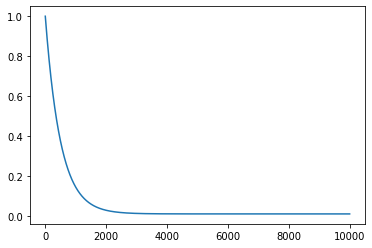

In [ ]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

## Deep Q Network

In [ ]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        #***********Añadido************
        #Usar dos redes, una para obtener v() y otra para a()
        self.a = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )

        self.v = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        #********************************

    # This method computes output Tensors from input Tensors. That is, given an state it returns an array with q(s,a) values for all actions
    def forward(self, x):
        #******Añadido**********
        output_a = self.a(x)
        output_v = self.v(x)
        
        return output_v + (output_a - output_a.mean())
        #***************************

  

In [ ]:
class Agent():
    def __init__(self, env):
        self.env = env
        self.replay_buffer = ReplayBuffer(1000)
        self.batch_size = 32
        self.gamma = 0.99
       
        self.model = DQN(self.env.observation_space.shape[0], self.env.action_space.n)
        self.optimizer = optim.Adam(self.model.parameters())

    # This method defines the epsilon value. It started with 1.0 and it decays until 0.01 value   
    def get_epsilon_value(self, frame_idx):
      epsilon_start = 1.0
      epsilon_final = 0.01
      epsilon_decay = 500
       
      epsilon = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
      return epsilon(frame_idx)
    
    # Given a state and epsilon value, this method returns an action following epsilong-greedy
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), requires_grad=False)
            q_value = self.model.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(self.env.action_space.n)
        return action

    # Given a model, it copyes the current model on it. 
    def update_target(self, target_model):
      target_model.load_state_dict(self.model.state_dict())

    # This method updates the weights 
    # It is solved using tensors
    def compute_td_loss(self, target_model):
      state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

      state      = Variable(torch.FloatTensor(np.float32(state)))
      next_state = Variable(torch.FloatTensor(np.float32(next_state)))
      action     = Variable(torch.LongTensor(action))
      reward     = Variable(torch.FloatTensor(reward))
      done       = Variable(torch.FloatTensor(done))
      
      q_values      = self.model.forward(state)
      next_q_values = self.model.forward(next_state)
      next_q_state_values = target_model(next_state) 

      q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
      next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
      #next_q_value = next_q_state_values.max(1)[0]
      expected_q_value = reward + self.gamma * next_q_value * (1 - done)
      
      loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
          
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      
      return loss

    # TODO
    # This method updates the weights 
    def compute_td_loss_our(self, target_model, n):
      # Obtain the mini_batch to train the weights.
      # state, action, reward, next_state, done are numpy arrays, each position corresponds to one experience
      state, action, reward, next_state, done, weights = self.replay_buffer.sample(self.batch_size)

      # Convert those numpy arrays to tensors. It is neccesary to work with Pytorch
      states_tensor      = Variable(torch.FloatTensor(np.float32(state)))       # current_state S
      actions_tensor     = Variable(torch.LongTensor(action))                   # action A
      next_states_tensor = Variable(torch.FloatTensor(np.float32(next_state)))  # next_state S'

      
      # The approximated q_values of each current state 
      q_values_tensor      = self.model.forward(states_tensor) # Q(S, A, W)

      # The approximated q_values of each next state calculated with the current_model and the target_model 
      next_q_values_current_model_tensor = self.model.forward(next_states_tensor) # Q(S', A', W)
      next_q_values_target_model_tensor = target_model.forward(next_states_tensor) # Q(S', A', W')

      # Convert the approximated next_states' q_values to numpy array. We are going to work with these arrays
      next_q_values_current_model = next_q_values_current_model_tensor.detach().numpy(); 
      next_q_values_target_model = next_q_values_target_model_tensor.detach().numpy(); 
      expected_q_value = np.zeros(self.batch_size)
      
      # TODO
      # input: next_q_values_current_model is a numpy array. In each element are stored all the approximated q values for the next state calculated with the current_model
      # input: next_q_values_target_model is a numpy array. In each element are stored all the approximated q values for the next state calculated with the target_model
      # input: reward is a numpy array with the rewards obtained in each experience of the mini_batch (batch_size)
      # output: expected_q_value is a numpy array. You have to store in each position the target value of each experience using next_q_values_target_model and reward elements 
      # note: all these numpy arrays has the same length: the length of the mini_batch (batch_size)
      #
      # for all the elements on the batch size
      #  calculate the target expected value and store in expected_q_value 

      for i in range(self.batch_size):      
        next_q_value = 0
        if not(done[i]):

          # with current model
          #next_q_value = max(next_q_values_current_model[i])

          # with current model action and target model approximation
          next_action = np.argmax(next_q_values_current_model[i])
          next_q_value = next_q_values_target_model[i][next_action]
          
        expected_q_value[i] = reward[i] + pow (self.gamma, n )*next_q_value

        #****Añadido******
        #actualizar el peso en el buffer
        self.replay_buffer.actualizar_peso(expected_q_value[i], i)
        #***********************

      # END TODO

      # Prepare data for the loss function
      q_value = q_values_tensor.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
      expected_q_values = torch.tensor(expected_q_value)

      # Loss function: to know how good the weights are
      # lossMSE = nn.MSELoss()  
      # loss = lossMSE(q_value.float(), expected_q_values.float())

      #****Añadido******
      loss  = (q_value - expected_q_values.detach()).pow(2) * torch.tensor(weights)
      loss  = loss.mean()
      #***********************

      # Based on the results of the loss function, the weights are updated with gradient descent
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      
      return loss

    # TODO
    # Method to train the agent
    def train(self, n):
      num_frames = 25000
      losses = []
      all_rewards = []
      all_losses = []
      episode_reward = 0
      episode_loss = 0
      target_model  = DQN(self.env.observation_space.shape[0], self.env.action_space.n)
      state = self.env.reset()

      # TODO
      # replay buffer attribute is empty
      # for each frame
      #   get current epsilon
      #   get action following epsilon greedy
      #   get next_state and reward
      #   add new experience to the replay buffer 
      #   update state
      #   update episode total reward
      #   if done
      #     reset environment
      #     append the episode total reward to all_rewards array
      #     set episode total reward to 0
      #   if experience replay has more elements than batch_size
      #     update the weights
      #   every 100 frames update the target model

      list_states = []
      list_actions = []
      list_rewards = []

      for frame_idx in range(1, num_frames + 1):
          epsilon = self.get_epsilon_value(frame_idx)
          action = self.act(state, epsilon) 
          

          next_state, reward, done, _ = self.env.step(action)
          list_states.append(state)
          list_actions.append(action)
          list_rewards.append(reward) 
          
          #Si estamos en un estado terminal, debemos subir todas las experiencias guardadas
          if done:
              for i in range (len(list_states)):
                 experience_reward = 0
                 for i in range(len(list_rewards)):
                  experience_reward += pow(self.gamma,i)*list_rewards[i]
                 list_rewards.pop(0)
                 self.replay_buffer.push(list_states.pop(0),list_actions.pop(0),experience_reward,state, done)  #Cada vez que se sube una experiencia, se borra su información de los arrays de guardado

              state = self.env.reset()
              all_rewards.append(episode_reward)
              episode_reward = 0 

          #Si no es terminal pero ya tenemos los n estado siguientes de un estado, se sube su experiencia
          if len(list_states) == n+1:
            
              experience_reward = 0
              for i in range(len(list_rewards)):
                experience_reward += pow(self.gamma,i)*list_rewards[i]
              list_rewards.pop(0)
              self.replay_buffer.push(list_states.pop(0),list_actions.pop(0),experience_reward,state, done)   #Cada vez que se sube una experiencia, se borra su información de los arrays de guardado
                
          if not done:
            state = next_state 
            episode_reward += reward  
              
          if len(current_model.replay_buffer) > self.batch_size:
              loss = self.compute_td_loss_our(target_model, n)
              losses.append(loss.data)

              episode_loss = loss

          # to visualize how the agent is learning    
          if frame_idx % 200 == 0:
              plot(frame_idx, all_rewards)

              plt.figure(figsize=(20,5))
              plt.subplot(131)
              plt.title("loss a lo largo del tiempo")
              plt.plot(losses)
              plt.show()
              
          if frame_idx % 100 == 0:
              self.update_target(target_model)  

      print("Recompensa media en el entrenamiento (con las recompensas de cada estado final): ", sum(all_rewards)/len(all_rewards))
      print("Loss medio en el entrenamiento:      (con los losses de cada frame):             ", sum(losses)/len(losses))
      #print("Loss medio en el entrenamiento:      (con los loses de cada estado final):       ", sum(all_losses)/len(all_losses))

    # This method runs one episode and generates a video to observe the result
    def test(self):
        video_folder="videos"

        remove_videos(video_folder=video_folder)

        # we are going to work over envVideo.
        envVideo = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)
                
        done = False #It is used to control if the episode is finished, if it is finished the environment must be reset
        state = envVideo.reset()

        total_reward = 0
        while not(done):          
            action = self.act(state, 0)
            next_state, reward, done, _ = envVideo.step(action)
            state = next_state
            total_reward +=reward
            if done:
              break
        envVideo.close()
        print("rew: ", total_reward)
        show_all_videos(video_folder=video_folder)
        
        

### Train the agent

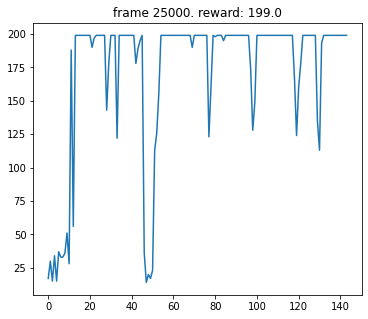

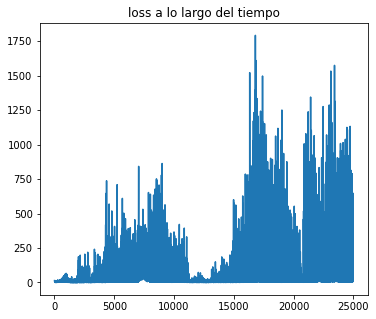

Recompensa media en el entrenamiento (con las recompensas de cada estado final):  171.9375
Loss medio en el entrenamiento:      (con los losses de cada frame):              tensor(77.5784, dtype=torch.float64)


In [ ]:
current_model = Agent(env)
current_model.train(3)

### Test the agent

In [ ]:
current_model.test()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment 

rew:  188.0
files:  ['videos/rl-video-episode-0.mp4']


Played: videos/rl-video-episode-0.mp4
